# Efficient training of energy-based models via spin-glass control [(arXiv:1910.01592)](https://arxiv.org/abs/1910.01592)
---

## Training on MNIST

**Authors**: Gorka Muñoz-Gil and Alejandro Pozas-Kerstjens

In this notebook we show how to train a RA-PID model on the MNIST dataset for generative purposes. For all the details on its theory, please take a look at [the associated paper](https://arxiv.org/abs/1910.01592). The example we show here corresponds to the models used to generate Fig. 6 from that paper.

Let's get into work. First, you will need to get two repositories: [ebm](https://github.com/apozas/ebm-torch), from which our models are created and [rapid](https://github.com/apozas/rapid), which contains all the details on training with RA and PID. This notebook should be placed on the same folder both repositories have been cloned, as:
```
your_folder
│   rapid
│   ebm
│   MNIST training.ipynb
```

We will then load the following objects:

In [2]:
from rapid.rapid import RA_RBM

For complex datasets, as shown in **Section V.4.B** of the paper, RAPID can be enhanced by performing a series of Gibbs Steps (GS) to the auxiliary patterns. Moreover, we will consider continuos patterns, restricted to the range $[-1,1]$. We must update our imported RA model in order to do such operations:

In [3]:
import copy
class RA_RBM_GS(RA_RBM):
    ''' RAPID Boltzmann machine with Gibbs Steps performed to the patterns for
    the calculation of the negative phase'''
    def __init__(self, n_visible=100, n_hidden=50, K=50, gibbs_steps = 0, 
                 optimizer=None, device=None, xi=None, sampler = None):
        super().__init__(n_visible, n_hidden, K, optimizer, device, xi) 
        
        self.gibbs_steps = gibbs_steps
        self.sampler = sampler
        
    def gibbs_steps_patterns(self):
        ''' Function that perfoms the Gibbs Steps to the patterns'''
        zero = copy.deepcopy(self.xi)
        for i in range(self.gibbs_steps):            
            zero[:, self.n_visible:] = self.sampler.get_h_from_v(
                                                       zero[:, :self.n_visible],
                                                       self.weights,
                                                       self.hbias)
            zero[:, :self.n_visible] = self.sampler.get_v_from_h(
                                                       zero[:, self.n_visible:],
                                                       self.weights,
                                                       self.vbias)  
        return zero[:, :self.n_visible]     
        
    def train(self, input_data):
        ''' Adapt usual training to get the negative phase by the
        function gibbs_steps_patterns'''
        
        for b, batch in enumerate(input_data):
            
            # Get data, positive and negative phase
            sample_data = batch.float()
            vpos = sample_data            
            vneg = self.gibbs_steps_patterns()
            
            # Weight updates. Includes momentum and weight decay if necessary
            xi_update = self.optimizer.get_updates(vpos, vneg, self.xi)            
            self.xi += xi_update            
            
            # Restrict the patterns to the range +- 1
            self.xi[self.xi > 1] = 1
            self.xi[self.xi < -1] = -1
                    
            # Generate new weights from the patterns
            self.get_params()

Now we import the rest of necessary functions:

In [4]:
from rapid.rapid import SGD_xi, ContrastiveDivergence_pm as CD

We will also need some general modules:

In [5]:
import torch
from torchvision import datasets
from torchvision.transforms import Lambda
from tqdm import tqdm

Now we import the MNIST dataset from `torchvision`. We will normalize it and create a validation dataset. To start, you should choose in which device (CPU or GPU) you want the model to train on.

In [12]:
# Choose device
gpu    = True     
device = torch.device('cuda' if gpu and torch.cuda.is_available() else 'cpu')

# Load the data from torchvision
threshold  = lambda x: (x > 0.3)
normalize  = lambda x: x / 255
data_mnist = datasets.MNIST('mnist', train=True, download=True)
data = data_mnist.train_data.type(torch.float)

# Normalize the data
data = torch.FloatTensor(data)
data = Lambda(normalize)(data)
data = Lambda(threshold)(data).type(torch.float)
data_transformed = (2 * (data.view((-1, 28**2))) - 1).to(device)   

# Create a validation set
ratio_val = 0.95
data = data_transformed[:int(len(data_transformed)*ratio_val)]
val_set = data_transformed[int(len(data_transformed)*ratio_val):]

Next, we set our machine:

In [32]:
hidd          = 3000     # Number of nodes in the hidden layer
vis           = 28**2    # Number of nodes in the visible layer
K_hebb        = 200      # Number of auxiliary patterns
learning_rate = 0.015    # Learning rate
epochs        = 500      # Number of training epochs
batch_size    = 8000     # Batch size
gibbs_steps   = 1        # Number of Gibbs Steps to the auxiliary patterns

rbm = RA_RBM_GS(n_visible=vis,
                n_hidden=hidd,
                sampler=CD(k=1),    # k is not used in this example
                optimizer=SGD_xi(learning_rate),
                device=device,
                K=K_hebb,
                gibbs_steps=gibbs_steps 
                ).to(device)

Now we train:

In [34]:
for epoch in tqdm(range(epochs)):
    train_loader = torch.utils.data.DataLoader(data,
                                               batch_size=int(batch_size),
                                               shuffle=True)
    rbm.train(train_loader)
    
    if epoch > 100 and rbm.optimizer.learning_rate > 1e-3:
            rbm.optimizer.learning_rate *= 0.99

100%|██████████| 500/500 [02:34<00:00,  3.25it/s]


And finally we generate new images by Gibbs sampling, recycling the model's sampler (`CD` in this particular example).

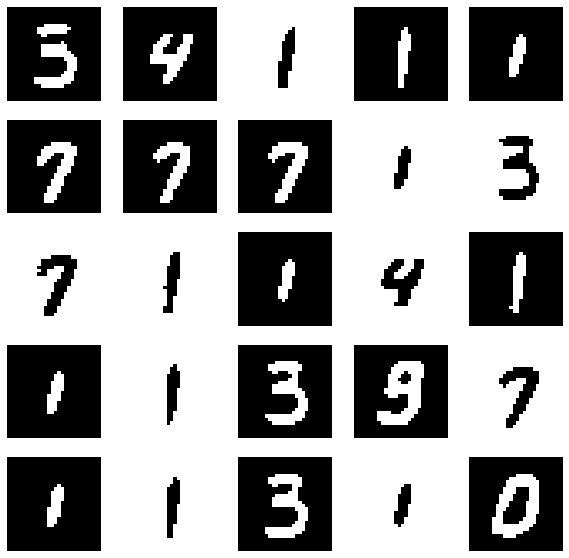

In [35]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    zero = torch.randint(high=2, size=(1, 28**2))
    zero = (2 * zero - 1).type(torch.FloatTensor).to(device)   
    for i in range(200):
        zero = rbm.sampler.get_h_from_v(zero, rbm.weights, rbm.hbias)
        zero = rbm.sampler.get_v_from_h(zero, rbm.weights, rbm.vbias)
    ax.imshow(zero.detach().cpu().numpy().reshape(28,28), cmap='gray')
    ax.set_axis_off()